<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/RNA/blob/main/PINN_para_equa%C3%A7%C3%A3o_do_calor_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código para testar a rede neural informada pela física para a equação de transferência de calor 1D.

---



A equação da difusão térmica é representada por:

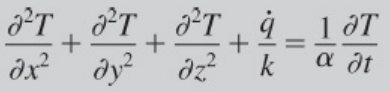

Como queremos estudar o caso 1D da equação, ela pode ser simplificada para:


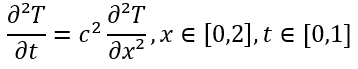


Sendo c² = α = k/(ρcp) que representa a difusividade térmica. Por fim, as condições iniciais e de contorno para esse caso serão, respectivamente:

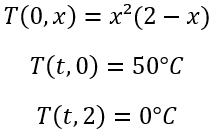

In [ ]:
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Criando a função para o modelo de rede neural
torch.manual_seed(123)
class modelo_RNA(nn.Module):

    def __init__(self, no_entrada, no_oculto, no_saida, n_camada_oculta):
        super().__init__()
        activation = nn.Tanh
        self.entrada_oculta = nn.Sequential(*[
                        nn.Linear(no_entrada, no_oculto),
                        activation()])
        self.oculta_oculta = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(no_oculto, no_oculto),
                            activation()]) for _ in range(n_camada_oculta)])
        self.oculta_saida = nn.Linear(no_oculto, no_saida)

    def forward(self, x, t):
      x = torch.cat((x,t), 1)
      x = self.entrada_oculta(x)
      x = self.oculta_oculta(x)
      x = self.oculta_saida(x)
      return x

In [ ]:
def plot_result(x,y,x_data,y_data,y_pred,xp=None):

    plt.figure()
    plt.plot(x,y, color="grey", label="Solução Exata")
    plt.plot(x,y_pred, color="tab:blue", label="Predição Rede Neural")
    plt.scatter(x_data, y_data, s=60, color="tab:red", label='Dados de Treino')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    #plt.xlim(-0.05, 2.1)
    #plt.ylim(-3, 4.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.xlabel('Tempo')
    plt.ylabel('Deslocamento')

In [ ]:
modelo = modelo_RNA(2, 40, 1, 3)
modelo = modelo.to(device)
custo = torch.nn.MSELoss()
otimizador = torch.optim.Adam(modelo.parameters(),lr=1e-4)

In [ ]:
def edp(x,t, c, modelo):
    u_pred = modelo(x,t) # the dependent variable u is given by the network based on independent variables x,t
    dx  = torch.autograd.grad(u_pred, x, torch.ones_like(u_pred), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx,  x, torch.ones_like(dx),  create_graph=True)[0]
    dt  = torch.autograd.grad(u_pred, t, torch.ones_like(u_pred), create_graph=True)[0]
    edp = dt - c*dx2
    return edp

In [ ]:
#Construindo os dados de x e y

x = torch.linspace(0,2,1000).view(-1,1) #uma matriz coluna com 1000 valores indo de 0 até 2
xc1 = torch.zeros((1000,1))
xc2 = 2*torch.ones((1000,1))

yc1 = 50*torch.ones((1000,1))
yc2 = torch.zeros((1000,1))
rho = 1600 #Massa específica
k = 40 #Coeficiente de condutividade térmica
cp = 4 #Calor especifico
difus = k/(rho*cp)

t_ini = torch.zeros((1000,1))
y_ini = (2-x)*x**2
t = torch.linspace(0,1,1000).view(-1,1)

In [ ]:
for i in range(30000):
    otimizador.zero_grad()

    modelo_ini_out = modelo(x, t_ini) #Valores para a condição inicial
    mse_ini = custo(modelo_ini_out, y_ini)

    modelo_c1 = modelo(xc1,t)
    modelo_c2 = modelo(xc2, t)
    mse_c1 = custo(modelo_c1, modelo_c2)

    #modelo_c2 = modelo(xc2, t)
    #mse_c2 = custo(modelo_c2, yc2)

    # Loss based on PDE
    all_zeros = np.zeros((1000,1))


    pt_x_collocation = Variable((x).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable((t).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

    f_out = edp(pt_x_collocation, pt_t_collocation, difus, modelo) # output of f(x,t)
    mse_f = custo(f_out, pt_all_zeros)

    # Combining the loss functions
    loss = mse_ini + mse_c1 + mse_f


    loss.backward() # This is for computing gradients using backward propagation
    otimizador.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
    	print(i,"Traning Loss:",loss.data)

A saída de streaming foi truncada nas últimas 5000 linhas.
25000 Traning Loss: tensor(2.1051e-06)
25001 Traning Loss: tensor(2.1062e-06)
25002 Traning Loss: tensor(2.1080e-06)
25003 Traning Loss: tensor(2.1108e-06)
25004 Traning Loss: tensor(2.1153e-06)
25005 Traning Loss: tensor(2.1223e-06)
25006 Traning Loss: tensor(2.1333e-06)
25007 Traning Loss: tensor(2.1510e-06)
25008 Traning Loss: tensor(2.1792e-06)
25009 Traning Loss: tensor(2.2247e-06)
25010 Traning Loss: tensor(2.2982e-06)
25011 Traning Loss: tensor(2.4184e-06)
25012 Traning Loss: tensor(2.6149e-06)
25013 Traning Loss: tensor(2.9390e-06)
25014 Traning Loss: tensor(3.4729e-06)
25015 Traning Loss: tensor(4.3589e-06)
25016 Traning Loss: tensor(5.8145e-06)
25017 Traning Loss: tensor(8.2086e-06)
25018 Traning Loss: tensor(1.2031e-05)
25019 Traning Loss: tensor(1.8030e-05)
25020 Traning Loss: tensor(2.6700e-05)
25021 Traning Loss: tensor(3.8228e-05)
25022 Traning Loss: tensor(5.0019e-05)
25023 Traning Loss: tensor(5.7533e-05)
25024

In [ ]:
y_pred = modelo(x, t)

In [ ]:
x_np = x.numpy()
t_np = t.numpy()
y_pred_np = y_pred.detach().numpy()

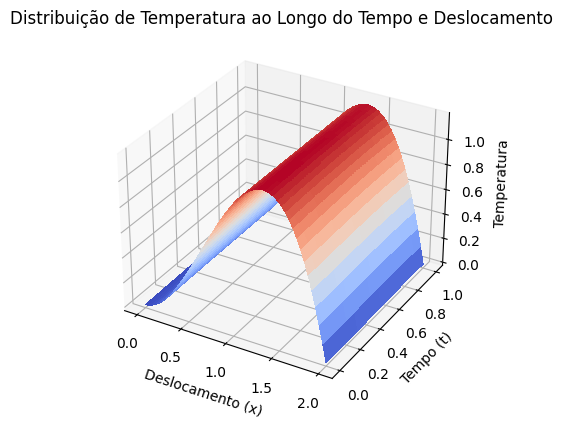

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ms_x, ms_t = np.meshgrid(x_np, t_np)
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = modelo(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax.set_xlabel('Deslocamento (x)')
ax.set_ylabel('Tempo (t)')
ax.set_zlabel('Temperatura')
ax.set_title('Distribuição de Temperatura ao Longo do Tempo e Deslocamento')

# Mostrar o gráfico
plt.show()

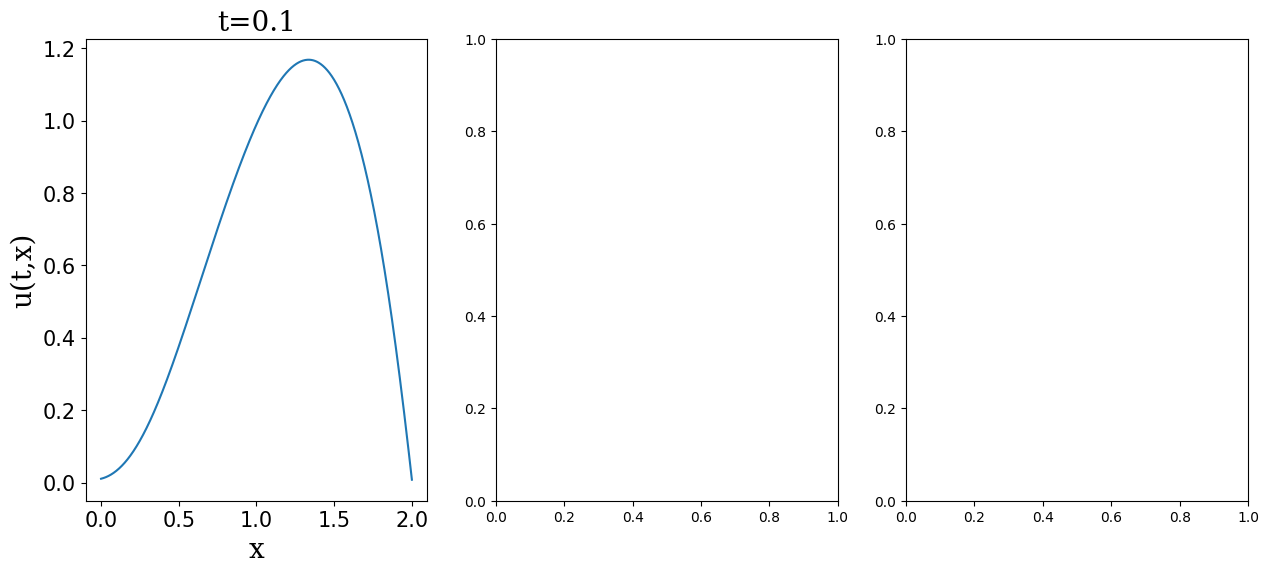

In [ ]:
t_1 = 1*torch.ones(1000,1)
t_1np = t_1.numpy()
y_pred = modelo(x, t_1)
y_pred_np = y_pred.detach().numpy()
fig,(ax1, ax2, ax3)  = plt.subplots(1,3,figsize=(15,6))
ax1.plot(x_np, y_pred_np)
#ax1.plot(x_np, U_1,'r*')
font1 = {'family':'serif','size':20}
ax1.set_title('t={}'.format(0.1), fontdict = font1)
ax1.set_xlabel('x', fontdict = font1)
ax1.set_ylabel('u(t,x)', fontdict = font1)
ax1.tick_params(labelsize=15)